In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import sys, os, time
from pathlib import Path
from tqdm import tqdm

import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [2]:
# device = torch.device("cuda:0")
device = torch.device("cuda:1")
# device = torch.device("cpu")

In [3]:
mnist = datasets.FashionMNIST()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

In [4]:
input_size = 784
output_size = 10

learning_rate = 0.0001
batch_size = 50

train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [5]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)

### Model Development

In [6]:
### does binary like encoding but continuous sin and cos
def generate_dimension_encoding(dim, binarize=True):
    num_d = int(np.ceil(np.log2(dim)))
    scale = np.arange(0, num_d, 1).reshape(1,-1)
    scale = (1/2)**scale
    
    index = np.arange(0, dim, 1).reshape(-1,1)
    mat = index*scale
    
    if binarize:
        mat = mat*np.pi/2
    sin_mat = np.sin(mat)**2
    cos_mat = np.cos(mat)**2
    pos_mat = np.concatenate((sin_mat, cos_mat), axis=1)
    return torch.Tensor(pos_mat)

### does exact binary encoding of position
def generate_dimension_encoding2(dim):
    num_d = int(np.ceil(np.log2(dim)))
    pos_mat = np.empty((dim, num_d))
    for i in range(dim):
        binary = np.binary_repr(i, width=num_d)
        pos_mat[i] = [float(a) for a in binary]
    
    pos_mat = np.concatenate((pos_mat, 1-pos_mat), axis=1)
    return torch.Tensor(pos_mat)


### does sin and cosine of position (meant to be used as addition)
def generate_dimension_encoding3(dim, binarize=False):
    num_d = int(np.ceil(np.log2(dim)))
    scale = np.arange(0, num_d, 1).reshape(1,-1)
    scale = (1/2)**scale
    
    index = np.arange(0, dim, 1).reshape(-1,1)
    mat = index*scale
    if binarize:
        mat = mat*np.pi/2
    sin_mat = np.sin(mat)
    cos_mat = np.cos(mat)
    pos_mat = np.concatenate((sin_mat, cos_mat), axis=1)
    return torch.Tensor(pos_mat)

#### as in positional encoding of attention transformer (as addition)
def generate_dimension_encoding4(dim, binarize=False):
    num_d = int(np.ceil(np.log2(dim)))
    scale = np.arange(0, num_d, 1).reshape(1,-1)
    scale = (1/10000)**(scale*2/dim)
    
    index = np.arange(0, dim, 1).reshape(-1,1)
    mat = index*scale
    if binarize:
        mat = mat*np.pi/2
    sin_mat = np.sin(mat)
    cos_mat = np.cos(mat)
    pos_mat = np.concatenate((sin_mat, cos_mat), axis=1)
    return torch.Tensor(pos_mat)

In [7]:
def construct_sequential_mlp(layer_dims, activation):
    layers = []
    for i in range(len(layer_dims)-1):
        _a = nn.Linear(layer_dims[i], layer_dims[i+1])
        layers += [_a, activation]
    layers = layers[:-1]
    return nn.Sequential(*layers)

# class DimMix_Layer_add(nn.Module):
    
#     def __init__(self,dim, pair, out_pair=None, hidden_ratio = [2], activation=nn.ReLU()):
#         super().__init__()
#         self.dim = dim
#         self.pair = pair
#         self.out_pair = out_pair
#         if out_pair is None:
#             self.out_pair = pair
#         if dim%pair != 0 :
#             raise ValueError(f"Dim: {dim} should be exactly divisible by Pair: {pair}")

#         self.pos_mat = generate_dimension_encoding4(dim//pair)
#         self.pos_mat = nn.Parameter(self.pos_mat)
        
#         self.linear = nn.Linear(pair, self.pos_mat.shape[1])
        
#         inp_dim = self.pos_mat.shape[1]
#         la_dims = [inp_dim] + [int(hr*inp_dim) for hr in hidden_ratio] + [self.out_pair]
#         self.net = construct_sequential_mlp(la_dims, activation)
        
#     def forward(self, x):
#         xs = x.shape
#         _x = self.linear(x.reshape(-1, self.pair))
#         _x = _x.reshape(-1, *self.pos_mat.shape)+self.pos_mat.unsqueeze(dim=0)
#         _x = self.net(_x.reshape(-1, self.pos_mat.shape[1]))
#         _x = _x.reshape(xs[0], -1)
#         return _x

In [8]:
dim = 16
pair = 2

X = torch.randn(2,dim)
if dim%pair != 0 :
    raise ValueError(f"Dim: {dim} should be exactly divisible by Pair: {pair}")
pos_mat = generate_dimension_encoding2(dim//pair)
pos_mat

tensor([[0., 0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1., 0.],
        [0., 1., 0., 1., 0., 1.],
        [0., 1., 1., 1., 0., 0.],
        [1., 0., 0., 0., 1., 1.],
        [1., 0., 1., 0., 1., 0.],
        [1., 1., 0., 0., 0., 1.],
        [1., 1., 1., 0., 0., 0.]])

In [9]:
# DimMix_Layer_add(dim, pair)(X).shape

In [10]:
kernel_dim = 4

centers = torch.rand(kernel_dim, dim)*1.5-0.5
scale = (torch.rand(1, kernel_dim)+0.25)*1

In [11]:
centers.shape

torch.Size([4, 16])

In [12]:
X.shape

torch.Size([2, 16])

In [13]:
K = (X.unsqueeze(1)-centers.unsqueeze(0))
K.shape

torch.Size([2, 4, 16])

In [14]:
K

tensor([[[ 0.5008,  2.1513, -0.2849,  0.8065, -1.5384, -0.4365,  0.5351,
          -1.0768,  0.5806, -0.7148, -0.8059, -0.5559, -1.9767,  0.3809,
           0.7844, -0.3681],
         [-0.5533,  1.2493, -0.1012,  0.4523, -1.5637,  0.1962,  0.8727,
          -1.1806,  0.5195, -1.0527, -1.4480,  0.3414, -2.1865,  0.4114,
           0.1488,  0.0503],
         [-0.1500,  2.1100, -0.3224, -0.2108, -1.1774, -0.1256,  1.3417,
          -2.4598,  0.4492, -0.9575, -1.0587, -0.1855, -1.7437,  0.5249,
           1.0188,  0.3988],
         [-0.6428,  1.5263,  0.0361,  0.1764, -2.5570, -0.4324,  1.8431,
          -2.4599, -0.1602, -1.0860, -0.7761, -0.1902, -2.0544, -0.5903,
           0.4900,  0.2471]],

        [[-0.3179,  1.2336,  0.2572, -0.6171, -0.8971,  0.8544, -2.1091,
          -0.8923,  1.8857,  0.0821, -0.4992, -0.6367, -2.7645,  2.4567,
          -1.3920, -0.9161],
         [-1.3720,  0.3315,  0.4408, -0.9713, -0.9224,  1.4871, -1.7714,
          -0.9962,  1.8246, -0.2557, -1.1413,  0.2

In [15]:
torch.norm(K, dim=2)**2, torch.sum(K**2, dim=2)

(tensor([[16.2233, 15.2868, 20.6625, 25.6621],
         [29.5213, 34.4794, 31.8729, 29.5301]]),
 tensor([[16.2233, 15.2867, 20.6625, 25.6621],
         [29.5213, 34.4794, 31.8729, 29.5301]]))

In [16]:
k = torch.exp(-(scale**2)*torch.sum(K**2, dim=2))
k.shape

torch.Size([2, 4])

In [17]:
k

tensor([[7.0866e-05, 2.9266e-02, 1.2195e-03, 5.4163e-17],
        [2.8126e-08, 3.4744e-04, 3.2009e-05, 1.9140e-19]])

In [18]:
x = torch.cat([X, k], dim=1)
x.shape

torch.Size([2, 20])

In [19]:
W = torch.randn(3, 2,2)
X = torch.randn(4, 3,2)

In [20]:
torch.bmm(X.transpose(0,1), W).transpose(0,1)

tensor([[[-0.1653, -0.2405],
         [-0.1168, -0.3692],
         [-2.3451, -0.3605]],

        [[ 1.3152, -0.0802],
         [-0.5500,  0.1280],
         [ 0.0555,  0.6240]],

        [[ 1.8403,  0.2152],
         [-0.0522,  1.0256],
         [ 0.1088,  1.3168]],

        [[-0.2191,  0.2196],
         [-1.0349,  0.0056],
         [-0.8366, -3.5813]]])

In [21]:
class RadialKernelize(nn.Module):
    def __init__(self, dim, kernel_dim):
        super().__init__()
        assert kernel_dim >= 0 and dim >=0
        self.kernel_dim = kernel_dim
        self.dim = dim
        if kernel_dim != 0:
            centers = torch.rand(kernel_dim, dim)*1.5-0.5
            scale = (torch.rand(1, kernel_dim)+0.25)*1
            self.centers = nn.Parameter(centers)
            self.scale = nn.Parameter(scale)
        
    def forward(self, x):
        if self.kernel_dim == 0: return x
        
#         print(x.shape, self.centers.shape)
        
        K = (x.unsqueeze(1)-self.centers.unsqueeze(0))
        K = torch.exp(-(self.scale**2)*torch.sum(K**2, dim=2))
        
        return torch.cat([x, K], dim=1)

In [22]:
class Kernalize_Rotate_BN_DimMix(nn.Module):
    
    def __init__(self, dim, pair, out_pair=None, hidden_ratio = [2], activation=nn.ReLU()):
        super().__init__()
        self.dim = dim
        self.pair = pair
        self.out_pair = out_pair
        if out_pair is None:
            self.out_pair = pair
        if dim%pair != 0 :
            raise ValueError(f"Dim: {dim} should be exactly divisible by Pair: {pair}")

        self.pos_mat = generate_dimension_encoding2(dim//pair)*2-1
        num_pos, inp_dim = self.pos_mat.shape
        ### there will be num_pos=dim//pair different inputs
        ### inp_dim will be the dimension of inputs
        if inp_dim < pair:
            self.pos_mat = torch.cat([self.pos_mat, torch.zeros(num_pos,pair-inp_dim)], dim=1)
            inp_dim = self.pos_mat.shape[1]
        
        self.pos_mat = nn.Parameter(self.pos_mat)
        
        self.kernalizer = RadialKernelize(pair, inp_dim-pair)
        
        self.rotate = torch.randn(num_pos, inp_dim, inp_dim)
        self.rotate /= torch.norm(self.rotate, dim=2, keepdim=True)
        self.rotate = nn.Parameter(self.rotate)
        
        self.bn = nn.BatchNorm1d(num_pos*inp_dim, affine=False)
        
        la_dims = [inp_dim] + [int(hr*inp_dim) for hr in hidden_ratio] + [self.out_pair]
        self.net = construct_sequential_mlp(la_dims, activation)
        
    def forward(self, x):
        xs = x.shape
        
        ### kernalizer takes batch of pair inputs and adds kernel to make shape=b*num_enc, input_dim
        _x = self.kernalizer(x.reshape(-1, self.pair))
        
        ### rotator rotates the data per dimension output shape=(b, num_enc, input_dim)
        _x = _x.reshape(-1, *self.pos_mat.shape)
        _x = torch.bmm(_x.transpose(0,1), self.rotate).transpose(0,1)
        
        ### Normalize the batch without encoding, ...can also normalize after encoding...
        _x = self.bn(_x.reshape(-1, self.pos_mat.shape[0]*self.pos_mat.shape[1]))
        
        ### similar to shift transform
        _x = _x.reshape(-1, *self.pos_mat.shape)+self.pos_mat.unsqueeze(dim=0)
        ### pass encoded input through the shared network
        _x = self.net(_x.reshape(-1, self.pos_mat.shape[1]))
        _x = _x.reshape(xs[0], -1)
        return _x

In [23]:
X = torch.randn(2,784)
Kernalize_Rotate_BN_DimMix(784, 4)

Kernalize_Rotate_BN_DimMix(
  (kernalizer): RadialKernelize()
  (bn): BatchNorm1d(3136, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (net): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=4, bias=True)
  )
)

In [24]:
196*4

784

In [25]:
class DimMix_Layer_add(nn.Module):
    
    def __init__(self,dim, pair, out_pair=None, hidden_ratio = [2], activation=nn.ReLU()):
        super().__init__()
        self.dim = dim
        self.pair = pair
        self.out_pair = out_pair
        if out_pair is None:
            self.out_pair = pair
        if dim%pair != 0 :
            raise ValueError(f"Dim: {dim} should be exactly divisible by Pair: {pair}")

        self.pos_mat = generate_dimension_encoding4(dim//pair)
        self.pos_mat = nn.Parameter(self.pos_mat)
        
        self.linear = nn.Linear(pair, self.pos_mat.shape[1])
        
        inp_dim = self.pos_mat.shape[1]
        la_dims = [inp_dim] + [int(hr*inp_dim) for hr in hidden_ratio] + [self.out_pair]
        self.net = construct_sequential_mlp(la_dims, activation)
        
    def forward(self, x):
        xs = x.shape
        _x = self.linear(x.reshape(-1, self.pair))
        _x = _x.reshape(-1, *self.pos_mat.shape)+self.pos_mat.unsqueeze(dim=0)
        _x = self.net(_x.reshape(-1, self.pos_mat.shape[1]))
        _x = _x.reshape(xs[0], -1)
        return _x


class DimMix_Layer_cat(nn.Module):
    
    def __init__(self,dim, pair, out_pair=None, hidden_ratio = [2], activation=nn.ReLU()):
        super().__init__()
        self.dim = dim
        self.pair = pair
        self.out_pair = out_pair
        if out_pair is None:
            self.out_pair = pair
        if dim%pair != 0 :
            raise ValueError(f"Dim: {dim} should be exactly divisible by Pair: {pair}")

        self.pos_mat = generate_dimension_encoding4(dim//pair)
        self.pos_mat = nn.Parameter(self.pos_mat)
        
        inp_dim = self.pos_mat.shape[1]+pair
        la_dims = [inp_dim] + [int(hr*inp_dim) for hr in hidden_ratio] + [self.out_pair]
        self.net = construct_sequential_mlp(la_dims, activation)
        self.bn = nn.BatchNorm1d(dim, affine=False)
        
    def forward(self, x):
        xs = x.shape
        x = self.bn(x)
        _x = x.reshape(-1, self.dim//self.pair, self.pair)
        _pm = self.pos_mat.expand(xs[0], *self.pos_mat.shape)
        _x = torch.cat([_x, _pm], dim=2)
        _x = _x.reshape(-1, self.pos_mat.shape[1]+self.pair)
        _x = self.net(_x).reshape(xs[0], -1)
        return _x

In [26]:
# DimMix_Layer_cat(dim, pair)(X).shape

In [27]:
class MLP_0(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784, 300)
        self.bn = nn.BatchNorm1d(300)
        self.l2 = nn.LeakyReLU()
        self.l3 = nn.Linear(300, 10)
        
    def forward(self, x):
        x = self.l1(x)
        x = self.bn(x)
        x = self.l2(x)
        x = self.l3(x)
        return x
    
class MLP_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784, 300)
        self.l3 = nn.Linear(300, 10)
        self.l2 = Kernalize_Rotate_BN_DimMix(300, 5, hidden_ratio=[5,5], activation=nn.ReLU())
#         self.l2 = DimMix_Layer_cat(300, 1, hidden_ratio=[5,5], activation=nn.ReLU())

        
    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        return x
    
    
class MLP_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.randindx = torch.randperm(784)
        hr = [5*2,5*2]
#         self.l1 = DimMix_Layer_add(784, 8, 4, hidden_ratio=hr, activation=nn.ReLU()) #784/2*1 = 392
#         self.l2 = DimMix_Layer_add(392, 8, 2, hidden_ratio=hr, activation=nn.ReLU()) #392/4*1 = 98
#         self.l3 = DimMix_Layer_add(98, 7, 3, hidden_ratio=hr, activation=nn.ReLU()) #98/7*3 = 42
        self.l1 = Kernalize_Rotate_BN_DimMix(784, 8, 4, hidden_ratio=hr, activation=nn.ReLU())
        self.l2 = Kernalize_Rotate_BN_DimMix(392, 8, 2, hidden_ratio=hr, activation=nn.ReLU())
        self.l3 = Kernalize_Rotate_BN_DimMix(98, 7, 3, hidden_ratio=hr, activation=nn.ReLU())
        self.l4 = nn.Linear(42, 10)
        
    def forward(self, x):
        x = x[:, self.randindx]
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        return x
    
# class MLP_3(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.randindx = torch.randperm(784)
#         hr = [5*2,5*2]
#         self.l1 = DimMix_Layer_add(784, 8, 8, hidden_ratio=hr, activation=nn.ReLU()) #784/2*1 = 392
#         self.l2 = DimMix_Layer_add(784, 8, 8, hidden_ratio=hr, activation=nn.ReLU()) #392/4*1 = 98
#         self.l3 = DimMix_Layer_add(784, 8, 8, hidden_ratio=hr, activation=nn.ReLU()) #98/7*3 = 42
#         self.l4 = nn.Linear(784, 10)
        
#     def forward(self, x):
#         x = x[:, self.randindx]
#         x = self.l1(x)
#         x = self.l2(x)
#         x = self.l3(x)
#         x = self.l4(x)
#         return x

In [28]:
X = torch.randn(2,784)

In [29]:
MLP_1()(X).shape

torch.Size([2, 10])

### Model Training

In [30]:
torch.manual_seed(0)
model = MLP_1().to(device)
model

MLP_1(
  (l1): Linear(in_features=784, out_features=300, bias=True)
  (l3): Linear(in_features=300, out_features=10, bias=True)
  (l2): Kernalize_Rotate_BN_DimMix(
    (kernalizer): RadialKernelize()
    (bn): BatchNorm1d(720, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (net): Sequential(
      (0): Linear(in_features=12, out_features=60, bias=True)
      (1): ReLU()
      (2): Linear(in_features=60, out_features=60, bias=True)
      (3): ReLU()
      (4): Linear(in_features=60, out_features=5, bias=True)
    )
  )
)

In [31]:
for p in model.parameters():
    print(p.shape)

torch.Size([300, 784])
torch.Size([300])
torch.Size([10, 300])
torch.Size([10])
torch.Size([60, 12])
torch.Size([60, 12, 12])
torch.Size([7, 5])
torch.Size([1, 7])
torch.Size([60, 12])
torch.Size([60])
torch.Size([60, 60])
torch.Size([60])
torch.Size([5, 60])
torch.Size([5])


In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [33]:
## MLP2: number of params:  38390 ; add
## MLP0: number of params:  39760
## MLP2: number of params:  27363 ; add

print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  252657


In [34]:
EPOCHS = 15*3
steps_ = 0
for epoch in range(EPOCHS):
    train_acc = 0
    train_count = 0
    for index in tqdm(range(train_size // batch_size)):
        steps_ += 1

        train_x = train_data[index * batch_size:(index + 1) * batch_size].to(device)
        train_y = train_label[index * batch_size:(index + 1) * batch_size].to(device)

        yout = model(train_x)
        loss = criterion(yout, train_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        outputs = tnn.Logits.logit_to_index(yout.data.cpu().numpy())
        train_acc += (outputs == train_y.data.cpu().numpy()).sum()
        train_count += len(outputs)

        if steps_%500==0:
            train_accuracy = train_acc/train_count
            train_acc, train_count = 0, 0
            
            print(f'\nEpoch: {epoch}, batch: {index}, step: {steps_}, loss: {float(loss)}')
            print(f'\tTrain acc: {train_accuracy*100}%')
            
            with torch.no_grad():
                test_acc, test_count = 0, 0
                model.eval()
                for _ti in range(len(test_data) // batch_size):
                    test_x = test_data[_ti * batch_size:(_ti + 1) * batch_size].to(device)
                    test_y_ = test_label_[_ti * batch_size:(_ti + 1) * batch_size]
                    yout = model(test_x)
                    outputs = tnn.Logits.logit_to_index(yout.cpu().numpy())
                    correct = (outputs == test_y_).sum()
                    test_acc += correct
                    test_count += len(test_x)
                model.train()

            print(f'\tTest acc: {test_acc/test_count*100}%, correct: {test_acc}/{test_count}')

 42%|████▏     | 503/1200 [00:01<00:02, 346.27it/s]


Epoch: 0, batch: 499, step: 500, loss: 0.6417284607887268
	Train acc: 75.02799999999999%
	Test acc: 82.89%, correct: 8289/10000


 87%|████████▋ | 1044/1200 [00:02<00:00, 349.63it/s]


Epoch: 0, batch: 999, step: 1000, loss: 0.7124103307723999
	Train acc: 84.404%
	Test acc: 84.59%, correct: 8459/10000


 27%|██▋       | 325/1200 [00:00<00:02, 350.37it/s]


Epoch: 1, batch: 299, step: 1500, loss: 0.456635981798172
	Train acc: 86.06%
	Test acc: 84.96000000000001%, correct: 8496/10000


 69%|██████▉   | 833/1200 [00:02<00:01, 354.53it/s]


Epoch: 1, batch: 799, step: 2000, loss: 0.43808573484420776
	Train acc: 86.696%
	Test acc: 84.63000000000001%, correct: 8463/10000


 12%|█▏        | 140/1200 [00:00<00:03, 317.39it/s]


Epoch: 2, batch: 99, step: 2500, loss: 0.2720431089401245
	Train acc: 87.78%
	Test acc: 86.41%, correct: 8641/10000


 54%|█████▍    | 646/1200 [00:01<00:01, 378.10it/s]


Epoch: 2, batch: 599, step: 3000, loss: 0.26992228627204895
	Train acc: 87.908%
	Test acc: 85.61999999999999%, correct: 8562/10000


 92%|█████████▏| 1101/1200 [00:02<00:00, 346.40it/s]


Epoch: 2, batch: 1099, step: 3500, loss: 0.37867632508277893
	Train acc: 89.0%
	Test acc: 86.86%, correct: 8686/10000


 34%|███▍      | 412/1200 [00:01<00:02, 347.13it/s]


Epoch: 3, batch: 399, step: 4000, loss: 0.40414634346961975
	Train acc: 88.94%
	Test acc: 86.99%, correct: 8699/10000


 76%|███████▋  | 916/1200 [00:02<00:00, 350.94it/s]


Epoch: 3, batch: 899, step: 4500, loss: 0.16645914316177368
	Train acc: 89.82%
	Test acc: 87.31%, correct: 8731/10000


 19%|█▉        | 229/1200 [00:00<00:02, 334.47it/s]


Epoch: 4, batch: 199, step: 5000, loss: 0.2208053469657898
	Train acc: 89.98%
	Test acc: 87.15%, correct: 8715/10000


 61%|██████▏   | 735/1200 [00:01<00:01, 351.10it/s]


Epoch: 4, batch: 699, step: 5500, loss: 0.2601064145565033
	Train acc: 90.28399999999999%
	Test acc: 87.68%, correct: 8768/10000


  4%|▍         | 46/1200 [00:00<00:02, 454.25it/s]


Epoch: 4, batch: 1199, step: 6000, loss: 0.24894341826438904
	Train acc: 90.80799999999999%
	Test acc: 87.02%, correct: 8702/10000


 42%|████▏     | 503/1200 [00:01<00:02, 346.24it/s]


Epoch: 5, batch: 499, step: 6500, loss: 0.29188260436058044
	Train acc: 90.876%
	Test acc: 88.03999999999999%, correct: 8804/10000


 84%|████████▍ | 1006/1200 [00:02<00:00, 347.91it/s]


Epoch: 5, batch: 999, step: 7000, loss: 0.2950561046600342
	Train acc: 91.764%
	Test acc: 88.24%, correct: 8824/10000


 27%|██▋       | 319/1200 [00:00<00:02, 339.23it/s]


Epoch: 6, batch: 299, step: 7500, loss: 0.2963556945323944
	Train acc: 91.72666666666667%
	Test acc: 87.02%, correct: 8702/10000


 68%|██████▊   | 810/1200 [00:02<00:01, 339.93it/s]


Epoch: 6, batch: 799, step: 8000, loss: 0.28899911046028137
	Train acc: 92.204%
	Test acc: 86.89%, correct: 8689/10000


 11%|█         | 134/1200 [00:00<00:03, 308.23it/s]


Epoch: 7, batch: 99, step: 8500, loss: 0.1811714619398117
	Train acc: 92.58%
	Test acc: 87.85%, correct: 8785/10000


 52%|█████▎    | 630/1200 [00:01<00:01, 340.23it/s]


Epoch: 7, batch: 599, step: 9000, loss: 0.1691053956747055
	Train acc: 92.636%
	Test acc: 87.29%, correct: 8729/10000


 93%|█████████▎| 1121/1200 [00:03<00:00, 259.22it/s]


Epoch: 7, batch: 1099, step: 9500, loss: 0.283099502325058
	Train acc: 93.184%
	Test acc: 88.19%, correct: 8819/10000


 34%|███▍      | 414/1200 [00:01<00:02, 346.98it/s]


Epoch: 8, batch: 399, step: 10000, loss: 0.17004252970218658
	Train acc: 93.23%
	Test acc: 87.82%, correct: 8782/10000


 77%|███████▋  | 920/1200 [00:02<00:00, 355.90it/s]


Epoch: 8, batch: 899, step: 10500, loss: 0.14409083127975464
	Train acc: 93.612%
	Test acc: 88.07000000000001%, correct: 8807/10000


 19%|█▉        | 233/1200 [00:00<00:02, 341.14it/s]


Epoch: 9, batch: 199, step: 11000, loss: 0.14759352803230286
	Train acc: 94.08%
	Test acc: 87.22999999999999%, correct: 8723/10000


 62%|██████▏   | 742/1200 [00:01<00:01, 351.57it/s]


Epoch: 9, batch: 699, step: 11500, loss: 0.08712755888700485
	Train acc: 94.116%
	Test acc: 88.26%, correct: 8826/10000


  4%|▍         | 45/1200 [00:00<00:02, 448.65it/s]


Epoch: 9, batch: 1199, step: 12000, loss: 0.16694484651088715
	Train acc: 94.372%
	Test acc: 87.61%, correct: 8761/10000


 42%|████▏     | 500/1200 [00:01<00:02, 345.56it/s]


Epoch: 10, batch: 499, step: 12500, loss: 0.1604030728340149
	Train acc: 94.596%
	Test acc: 88.27000000000001%, correct: 8827/10000


 84%|████████▎ | 1004/1200 [00:02<00:00, 351.51it/s]


Epoch: 10, batch: 999, step: 13000, loss: 0.18383705615997314
	Train acc: 94.91199999999999%
	Test acc: 88.29%, correct: 8829/10000


 27%|██▋       | 325/1200 [00:00<00:02, 347.73it/s]


Epoch: 11, batch: 299, step: 13500, loss: 0.22762079536914825
	Train acc: 95.14%
	Test acc: 87.63%, correct: 8763/10000


 69%|██████▉   | 830/1200 [00:02<00:01, 346.27it/s]


Epoch: 11, batch: 799, step: 14000, loss: 0.19451496005058289
	Train acc: 95.312%
	Test acc: 87.19%, correct: 8719/10000


 11%|█         | 132/1200 [00:00<00:03, 306.58it/s]


Epoch: 12, batch: 99, step: 14500, loss: 0.12218130379915237
	Train acc: 95.84%
	Test acc: 87.9%, correct: 8790/10000


 53%|█████▎    | 634/1200 [00:01<00:01, 347.46it/s]


Epoch: 12, batch: 599, step: 15000, loss: 0.1020694226026535
	Train acc: 95.572%
	Test acc: 86.9%, correct: 8690/10000


 94%|█████████▍| 1134/1200 [00:02<00:00, 345.86it/s]


Epoch: 12, batch: 1099, step: 15500, loss: 0.1779717057943344
	Train acc: 96.00800000000001%
	Test acc: 88.07000000000001%, correct: 8807/10000


 34%|███▍      | 409/1200 [00:01<00:02, 346.54it/s]


Epoch: 13, batch: 399, step: 16000, loss: 0.11342331767082214
	Train acc: 96.07%
	Test acc: 87.28%, correct: 8728/10000


 76%|███████▌  | 912/1200 [00:02<00:00, 350.53it/s]


Epoch: 13, batch: 899, step: 16500, loss: 0.06302999705076218
	Train acc: 96.328%
	Test acc: 87.86%, correct: 8786/10000


 19%|█▉        | 229/1200 [00:00<00:02, 332.59it/s]


Epoch: 14, batch: 199, step: 17000, loss: 0.06921472400426865
	Train acc: 96.39%
	Test acc: 87.27000000000001%, correct: 8727/10000


 61%|██████    | 728/1200 [00:01<00:01, 350.07it/s]


Epoch: 14, batch: 699, step: 17500, loss: 0.05206023529171944
	Train acc: 96.6%
	Test acc: 87.76%, correct: 8776/10000


  0%|          | 0/1200 [00:00<?, ?it/s]


Epoch: 14, batch: 1199, step: 18000, loss: 0.09090104699134827
	Train acc: 96.96000000000001%
	Test acc: 87.31%, correct: 8731/10000


 46%|████▌     | 546/1200 [00:01<00:01, 368.02it/s]


Epoch: 15, batch: 499, step: 18500, loss: 0.09241339564323425
	Train acc: 96.848%
	Test acc: 88.63%, correct: 8863/10000


 86%|████████▋ | 1036/1200 [00:02<00:00, 337.54it/s]


Epoch: 15, batch: 999, step: 19000, loss: 0.13370923697948456
	Train acc: 97.20400000000001%
	Test acc: 87.29%, correct: 8729/10000


 26%|██▌       | 310/1200 [00:00<00:02, 329.38it/s]


Epoch: 16, batch: 299, step: 19500, loss: 0.20479704439640045
	Train acc: 97.01333333333334%
	Test acc: 87.26%, correct: 8726/10000


 70%|███████   | 846/1200 [00:02<00:00, 371.79it/s]


Epoch: 16, batch: 799, step: 20000, loss: 0.1398906260728836
	Train acc: 97.46000000000001%
	Test acc: 86.66%, correct: 8666/10000


 11%|█▏        | 137/1200 [00:00<00:03, 309.79it/s]


Epoch: 17, batch: 99, step: 20500, loss: 0.09945130348205566
	Train acc: 97.58%
	Test acc: 87.66000000000001%, correct: 8766/10000


 53%|█████▎    | 635/1200 [00:01<00:01, 342.38it/s]


Epoch: 17, batch: 599, step: 21000, loss: 0.03580522909760475
	Train acc: 97.5%
	Test acc: 87.1%, correct: 8710/10000


 94%|█████████▍| 1128/1200 [00:02<00:00, 340.25it/s]


Epoch: 17, batch: 1099, step: 21500, loss: 0.14046825468540192
	Train acc: 97.688%
	Test acc: 87.35000000000001%, correct: 8735/10000


 34%|███▍      | 406/1200 [00:01<00:02, 335.02it/s]


Epoch: 18, batch: 399, step: 22000, loss: 0.14258092641830444
	Train acc: 97.655%
	Test acc: 86.79%, correct: 8679/10000


 78%|███████▊  | 939/1200 [00:02<00:00, 339.77it/s]


Epoch: 18, batch: 899, step: 22500, loss: 0.04330374300479889
	Train acc: 97.74000000000001%
	Test acc: 86.82%, correct: 8682/10000


 19%|█▊        | 224/1200 [00:00<00:03, 323.57it/s]


Epoch: 19, batch: 199, step: 23000, loss: 0.032198451459407806
	Train acc: 97.47%
	Test acc: 87.35000000000001%, correct: 8735/10000


 59%|█████▉    | 713/1200 [00:01<00:01, 337.15it/s]


Epoch: 19, batch: 699, step: 23500, loss: 0.09953062981367111
	Train acc: 97.64%
	Test acc: 87.71%, correct: 8771/10000


  0%|          | 0/1200 [00:00<?, ?it/s]


Epoch: 19, batch: 1199, step: 24000, loss: 0.10329955816268921
	Train acc: 98.124%
	Test acc: 86.79%, correct: 8679/10000


 45%|████▌     | 543/1200 [00:01<00:01, 348.95it/s]


Epoch: 20, batch: 499, step: 24500, loss: 0.04710052162408829
	Train acc: 97.792%
	Test acc: 87.62%, correct: 8762/10000


 87%|████████▋ | 1044/1200 [00:02<00:00, 348.63it/s]


Epoch: 20, batch: 999, step: 25000, loss: 0.020007610321044922
	Train acc: 98.032%
	Test acc: 87.42999999999999%, correct: 8743/10000


 27%|██▋       | 322/1200 [00:00<00:02, 338.81it/s]


Epoch: 21, batch: 299, step: 25500, loss: 0.19166319072246552
	Train acc: 98.07333333333334%
	Test acc: 86.50999999999999%, correct: 8651/10000


 68%|██████▊   | 817/1200 [00:02<00:01, 338.47it/s]


Epoch: 21, batch: 799, step: 26000, loss: 0.10129861533641815
	Train acc: 98.14399999999999%
	Test acc: 86.25%, correct: 8625/10000


 12%|█▏        | 138/1200 [00:00<00:03, 313.86it/s]


Epoch: 22, batch: 99, step: 26500, loss: 0.04675709828734398
	Train acc: 98.06%
	Test acc: 87.78%, correct: 8778/10000


 53%|█████▎    | 638/1200 [00:01<00:01, 338.35it/s]


Epoch: 22, batch: 599, step: 27000, loss: 0.007879160344600677
	Train acc: 98.2%
	Test acc: 87.01%, correct: 8701/10000


 94%|█████████▍| 1126/1200 [00:02<00:00, 337.99it/s]


Epoch: 22, batch: 1099, step: 27500, loss: 0.13178132474422455
	Train acc: 98.48400000000001%
	Test acc: 86.92%, correct: 8692/10000


 33%|███▎      | 401/1200 [00:01<00:02, 330.70it/s]


Epoch: 23, batch: 399, step: 28000, loss: 0.23471499979496002
	Train acc: 97.925%
	Test acc: 87.35000000000001%, correct: 8735/10000


 75%|███████▌  | 905/1200 [00:02<00:00, 348.21it/s]


Epoch: 23, batch: 899, step: 28500, loss: 0.008038056083023548
	Train acc: 98.44000000000001%
	Test acc: 87.53%, correct: 8753/10000


 19%|█▉        | 228/1200 [00:00<00:02, 334.87it/s]


Epoch: 24, batch: 199, step: 29000, loss: 0.044366251677274704
	Train acc: 98.46000000000001%
	Test acc: 87.18%, correct: 8718/10000


 61%|██████    | 729/1200 [00:01<00:01, 351.61it/s]


Epoch: 24, batch: 699, step: 29500, loss: 0.04100091755390167
	Train acc: 98.288%
	Test acc: 87.57000000000001%, correct: 8757/10000


  4%|▍         | 46/1200 [00:00<00:02, 453.41it/s]


Epoch: 24, batch: 1199, step: 30000, loss: 0.08779096603393555
	Train acc: 98.396%
	Test acc: 86.87%, correct: 8687/10000


 45%|████▌     | 544/1200 [00:01<00:01, 367.21it/s]


Epoch: 25, batch: 499, step: 30500, loss: 0.007160092703998089
	Train acc: 98.328%
	Test acc: 88.0%, correct: 8800/10000


 87%|████████▋ | 1041/1200 [00:02<00:00, 345.10it/s]


Epoch: 25, batch: 999, step: 31000, loss: 0.05127067491412163
	Train acc: 98.604%
	Test acc: 87.28%, correct: 8728/10000


 27%|██▋       | 319/1200 [00:00<00:02, 343.68it/s]


Epoch: 26, batch: 299, step: 31500, loss: 0.020589975640177727
	Train acc: 98.42%
	Test acc: 86.42999999999999%, correct: 8643/10000


 68%|██████▊   | 815/1200 [00:02<00:01, 343.41it/s]


Epoch: 26, batch: 799, step: 32000, loss: 0.12032860517501831
	Train acc: 98.6%
	Test acc: 86.89%, correct: 8689/10000


 11%|█         | 133/1200 [00:00<00:03, 309.08it/s]


Epoch: 27, batch: 99, step: 32500, loss: 0.043822165578603745
	Train acc: 98.68%
	Test acc: 87.7%, correct: 8770/10000


 53%|█████▎    | 632/1200 [00:01<00:01, 350.71it/s]


Epoch: 27, batch: 599, step: 33000, loss: 0.004344072192907333
	Train acc: 98.624%
	Test acc: 87.99%, correct: 8799/10000


 94%|█████████▍| 1132/1200 [00:02<00:00, 346.08it/s]


Epoch: 27, batch: 1099, step: 33500, loss: 0.06297355890274048
	Train acc: 98.60799999999999%
	Test acc: 87.94%, correct: 8794/10000


 34%|███▍      | 411/1200 [00:01<00:02, 344.07it/s]


Epoch: 28, batch: 399, step: 34000, loss: 0.08676134794950485
	Train acc: 98.625%
	Test acc: 87.28%, correct: 8728/10000


 75%|███████▌  | 902/1200 [00:02<00:00, 340.52it/s]


Epoch: 28, batch: 899, step: 34500, loss: 0.008327343501150608
	Train acc: 98.524%
	Test acc: 87.17%, correct: 8717/10000


 19%|█▉        | 228/1200 [00:00<00:02, 332.39it/s]


Epoch: 29, batch: 199, step: 35000, loss: 0.09718798846006393
	Train acc: 98.6%
	Test acc: 87.7%, correct: 8770/10000


 60%|██████    | 720/1200 [00:01<00:01, 338.64it/s]


Epoch: 29, batch: 699, step: 35500, loss: 0.023233041167259216
	Train acc: 98.72800000000001%
	Test acc: 86.66%, correct: 8666/10000


  0%|          | 0/1200 [00:00<?, ?it/s]


Epoch: 29, batch: 1199, step: 36000, loss: 0.06304596364498138
	Train acc: 98.48400000000001%
	Test acc: 87.79%, correct: 8779/10000


 43%|████▎     | 517/1200 [00:01<00:02, 331.10it/s]


Epoch: 30, batch: 499, step: 36500, loss: 0.061865970492362976
	Train acc: 98.752%
	Test acc: 87.42%, correct: 8742/10000


 85%|████████▍ | 1017/1200 [00:02<00:00, 335.91it/s]


Epoch: 30, batch: 999, step: 37000, loss: 0.020496927201747894
	Train acc: 98.688%
	Test acc: 87.44%, correct: 8744/10000


 27%|██▋       | 320/1200 [00:00<00:02, 342.86it/s]


Epoch: 31, batch: 299, step: 37500, loss: 0.04589195176959038
	Train acc: 98.88%
	Test acc: 87.2%, correct: 8720/10000


 69%|██████▉   | 826/1200 [00:02<00:01, 353.78it/s]


Epoch: 31, batch: 799, step: 38000, loss: 0.08491016179323196
	Train acc: 98.904%
	Test acc: 86.92%, correct: 8692/10000


 12%|█▏        | 141/1200 [00:00<00:03, 319.26it/s]


Epoch: 32, batch: 99, step: 38500, loss: 0.012724551372230053
	Train acc: 98.58%
	Test acc: 87.62%, correct: 8762/10000


 53%|█████▎    | 638/1200 [00:01<00:01, 341.46it/s]


Epoch: 32, batch: 599, step: 39000, loss: 0.016529392451047897
	Train acc: 98.88%
	Test acc: 87.96000000000001%, correct: 8796/10000


 95%|█████████▍| 1138/1200 [00:02<00:00, 351.99it/s]


Epoch: 32, batch: 1099, step: 39500, loss: 0.05691108852624893
	Train acc: 98.444%
	Test acc: 88.08%, correct: 8808/10000


 35%|███▍      | 417/1200 [00:01<00:02, 350.89it/s]


Epoch: 33, batch: 399, step: 40000, loss: 0.017605535686016083
	Train acc: 98.95%
	Test acc: 87.78%, correct: 8778/10000


 77%|███████▋  | 922/1200 [00:02<00:00, 351.63it/s]


Epoch: 33, batch: 899, step: 40500, loss: 0.06402702629566193
	Train acc: 98.94%
	Test acc: 87.64%, correct: 8764/10000


 19%|█▉        | 232/1200 [00:00<00:02, 340.30it/s]


Epoch: 34, batch: 199, step: 41000, loss: 0.03515429422259331
	Train acc: 98.77%
	Test acc: 88.07000000000001%, correct: 8807/10000


 61%|██████▏   | 736/1200 [00:01<00:01, 350.00it/s]


Epoch: 34, batch: 699, step: 41500, loss: 0.012287679128348827
	Train acc: 98.628%
	Test acc: 87.96000000000001%, correct: 8796/10000


  4%|▍         | 46/1200 [00:00<00:02, 459.78it/s]


Epoch: 34, batch: 1199, step: 42000, loss: 0.041172515600919724
	Train acc: 98.932%
	Test acc: 87.22999999999999%, correct: 8723/10000


 42%|████▏     | 506/1200 [00:01<00:01, 352.89it/s]


Epoch: 35, batch: 499, step: 42500, loss: 0.009476162493228912
	Train acc: 99.104%
	Test acc: 88.06%, correct: 8806/10000


 85%|████████▍ | 1015/1200 [00:02<00:00, 353.70it/s]


Epoch: 35, batch: 999, step: 43000, loss: 0.01689865067601204
	Train acc: 98.8%
	Test acc: 88.06%, correct: 8806/10000


 27%|██▋       | 320/1200 [00:00<00:02, 342.19it/s]


Epoch: 36, batch: 299, step: 43500, loss: 0.017360050231218338
	Train acc: 98.89333333333333%
	Test acc: 87.49%, correct: 8749/10000


 68%|██████▊   | 821/1200 [00:02<00:01, 351.00it/s]


Epoch: 36, batch: 799, step: 44000, loss: 0.11539305001497269
	Train acc: 98.88%
	Test acc: 86.8%, correct: 8680/10000


 12%|█▏        | 140/1200 [00:00<00:03, 310.84it/s]


Epoch: 37, batch: 99, step: 44500, loss: 0.10693240165710449
	Train acc: 98.9%
	Test acc: 87.82%, correct: 8782/10000


 53%|█████▎    | 637/1200 [00:01<00:01, 350.23it/s]


Epoch: 37, batch: 599, step: 45000, loss: 0.001741910818964243
	Train acc: 99.152%
	Test acc: 88.14%, correct: 8814/10000


 96%|█████████▌| 1147/1200 [00:02<00:00, 380.90it/s]


Epoch: 37, batch: 1099, step: 45500, loss: 0.11355774104595184
	Train acc: 98.992%
	Test acc: 87.57000000000001%, correct: 8757/10000


 35%|███▍      | 418/1200 [00:01<00:02, 343.94it/s]


Epoch: 38, batch: 399, step: 46000, loss: 0.0346912182867527
	Train acc: 99.115%
	Test acc: 86.66%, correct: 8666/10000


 76%|███████▋  | 917/1200 [00:02<00:00, 346.24it/s]


Epoch: 38, batch: 899, step: 46500, loss: 0.01060026977211237
	Train acc: 98.964%
	Test acc: 87.9%, correct: 8790/10000


 19%|█▉        | 227/1200 [00:00<00:02, 332.41it/s]


Epoch: 39, batch: 199, step: 47000, loss: 0.0007879756158217788
	Train acc: 99.14%
	Test acc: 87.64999999999999%, correct: 8765/10000


 60%|██████    | 726/1200 [00:01<00:01, 345.48it/s]


Epoch: 39, batch: 699, step: 47500, loss: 0.00830263365060091
	Train acc: 99.132%
	Test acc: 87.75%, correct: 8775/10000


  4%|▍         | 46/1200 [00:00<00:02, 457.58it/s]


Epoch: 39, batch: 1199, step: 48000, loss: 0.044709090143442154
	Train acc: 98.964%
	Test acc: 87.76%, correct: 8776/10000


 42%|████▏     | 505/1200 [00:01<00:01, 348.30it/s]


Epoch: 40, batch: 499, step: 48500, loss: 0.00432682316750288
	Train acc: 98.82%
	Test acc: 87.97%, correct: 8797/10000


 84%|████████▍ | 1007/1200 [00:02<00:00, 346.88it/s]


Epoch: 40, batch: 999, step: 49000, loss: 0.028795871883630753
	Train acc: 98.952%
	Test acc: 87.96000000000001%, correct: 8796/10000


 27%|██▋       | 321/1200 [00:00<00:02, 341.43it/s]


Epoch: 41, batch: 299, step: 49500, loss: 0.0029222420416772366
	Train acc: 99.08%
	Test acc: 87.3%, correct: 8730/10000


 68%|██████▊   | 818/1200 [00:02<00:01, 341.69it/s]


Epoch: 41, batch: 799, step: 50000, loss: 0.18374304473400116
	Train acc: 98.94800000000001%
	Test acc: 88.09%, correct: 8809/10000


 11%|█▏        | 137/1200 [00:00<00:03, 318.03it/s]


Epoch: 42, batch: 99, step: 50500, loss: 0.0571090467274189
	Train acc: 99.2%
	Test acc: 87.76%, correct: 8776/10000


 53%|█████▎    | 636/1200 [00:01<00:01, 345.65it/s]


Epoch: 42, batch: 599, step: 51000, loss: 0.0008164274622686207
	Train acc: 99.3%
	Test acc: 87.88%, correct: 8788/10000


 94%|█████████▍| 1134/1200 [00:02<00:00, 344.19it/s]


Epoch: 42, batch: 1099, step: 51500, loss: 0.09479966014623642
	Train acc: 99.092%
	Test acc: 87.83%, correct: 8783/10000


 34%|███▍      | 412/1200 [00:01<00:02, 346.96it/s]


Epoch: 43, batch: 399, step: 52000, loss: 0.03905083239078522
	Train acc: 99.14%
	Test acc: 87.89%, correct: 8789/10000


 76%|███████▌  | 908/1200 [00:02<00:00, 351.11it/s]


Epoch: 43, batch: 899, step: 52500, loss: 0.038824789226055145
	Train acc: 99.1%
	Test acc: 88.16000000000001%, correct: 8816/10000


 19%|█▉        | 229/1200 [00:00<00:02, 329.86it/s]


Epoch: 44, batch: 199, step: 53000, loss: 0.006798767019063234
	Train acc: 99.22%
	Test acc: 87.77000000000001%, correct: 8777/10000


 61%|██████    | 733/1200 [00:01<00:01, 349.65it/s]


Epoch: 44, batch: 699, step: 53500, loss: 0.011095782741904259
	Train acc: 99.09599999999999%
	Test acc: 88.14%, correct: 8814/10000


100%|██████████| 1200/1200 [00:02<00:00, 403.55it/s]


Epoch: 44, batch: 1199, step: 54000, loss: 0.049971021711826324
	Train acc: 99.208%
	Test acc: 87.83%, correct: 8783/10000


In [35]:
len(test_data)//batch_size

200

In [36]:
## MLP2
# Train acc: 87.96000000000001%
# 	Test acc: 86.27%, correct: 8627/10000
## MLP0
# Train acc: 89.05999999999999%
# 	Test acc: 87.3%, correct: 8730/10000

## Visualize first activations --paired embeddings

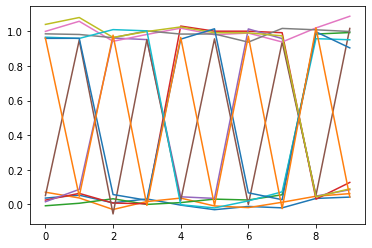

In [37]:
%matplotlib inline
plt.plot(model.l2.pos_mat.cpu().data[:10])

In [38]:
### inputs from -1, 1 for every dimension in a batch
X = torch.linspace(-1, 1, steps=20).expand(300, -1).transpose(0,1)
X.shape

torch.Size([20, 300])

In [39]:
model.eval()
ys = model.l2(X.to(device)).data.cpu()
ys.shape

torch.Size([20, 300])

In [40]:
ys[0]

tensor([-8.7173e-01,  5.3209e+01,  6.9542e-01, -3.4501e+01, -1.7463e+01,
        -1.0260e+00,  7.2296e+01,  1.6003e+01, -3.7312e+01, -3.8684e+01,
         7.1856e-01,  3.6802e+01,  1.0485e+01, -1.6795e+01, -2.2388e+01,
         3.9187e+00,  2.5388e+01,  1.0194e+01, -1.4361e+01, -1.7943e+01,
        -8.0728e+00,  7.4399e+01,  7.3639e+00, -3.3348e+01, -2.8310e+01,
         7.1615e+00,  3.6045e+01,  5.7253e+00, -2.6806e+01, -2.1413e+01,
         1.2631e+01,  6.0944e+01,  1.6252e+01, -4.1168e+01, -3.7420e+01,
        -7.8698e-01,  7.0719e+01, -1.9737e+01, -5.1450e+01, -1.6388e+01,
         7.2807e+00,  1.8031e+01,  1.1816e+01, -1.0515e+01, -1.8432e+01,
        -8.8868e+00,  1.5094e+01, -1.8227e+01, -5.4566e+00,  1.1214e+01,
        -2.1227e+01,  5.0307e+01, -4.7875e+01, -3.1973e+01,  2.2030e+01,
         4.8722e+00,  1.6707e+01,  8.5974e+00, -1.0153e+01, -1.4685e+01,
        -4.8952e+00,  1.2041e+02,  1.6830e+01, -6.5312e+01, -5.4875e+01,
         5.7418e+00,  3.5355e+01,  1.7469e+01, -1.7

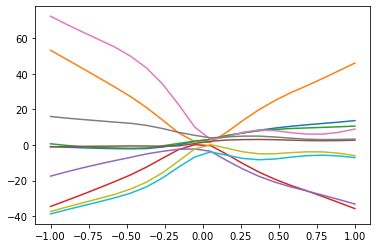

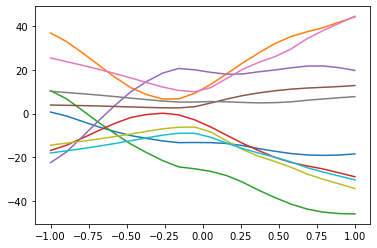

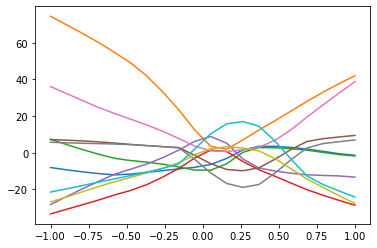

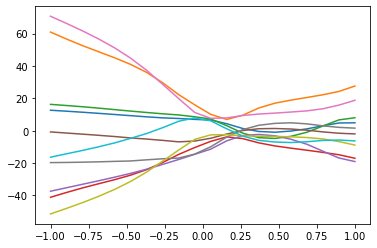

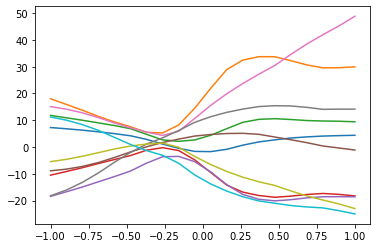

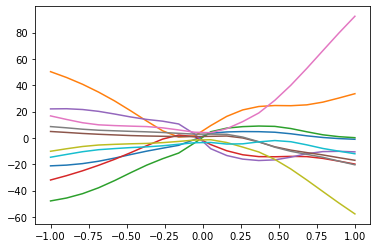

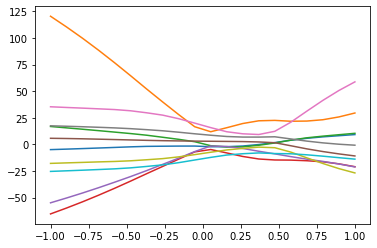

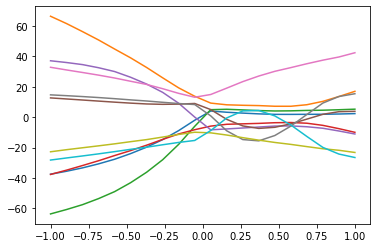

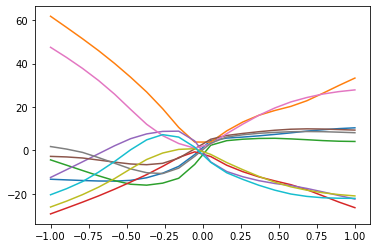

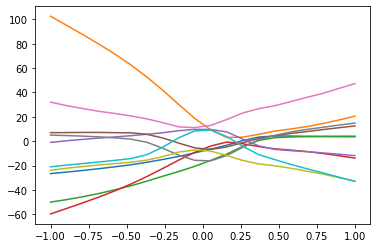

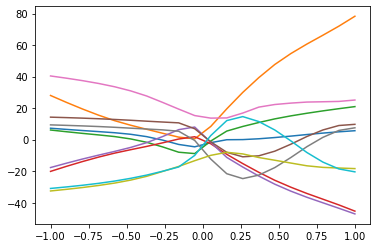

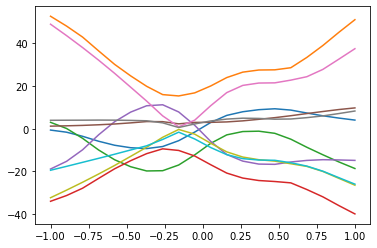

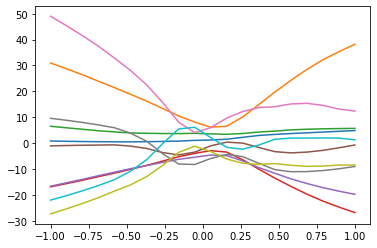

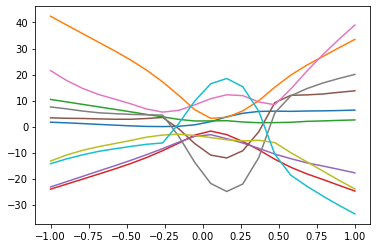

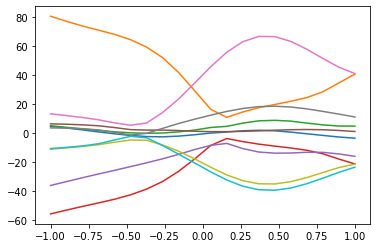

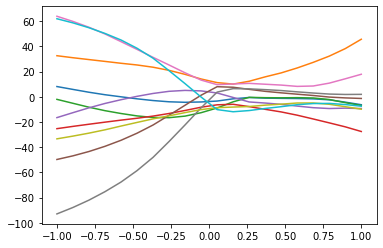

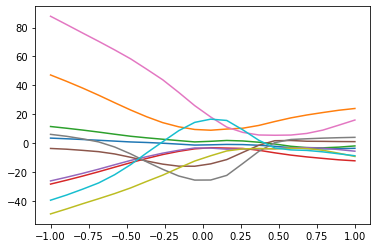

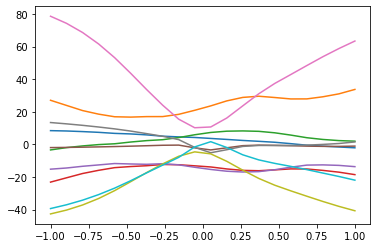

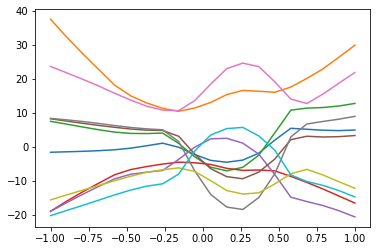

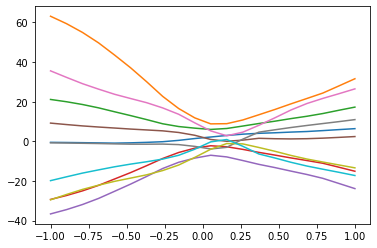

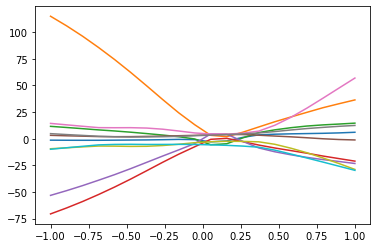

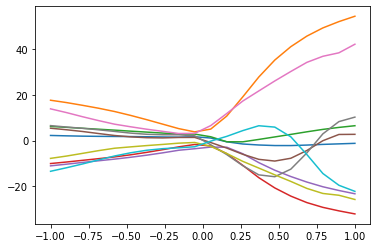

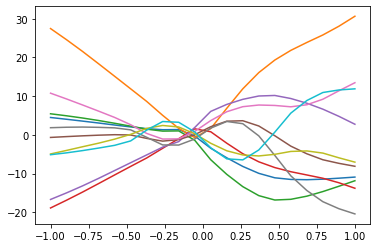

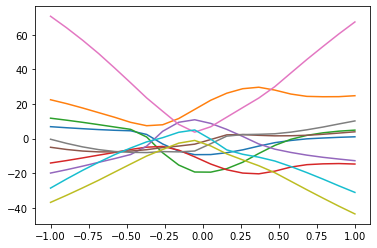

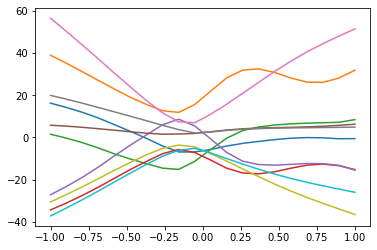

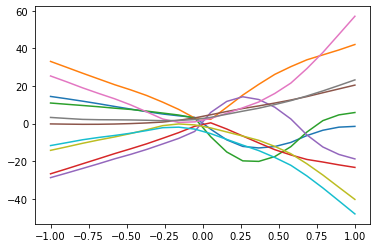

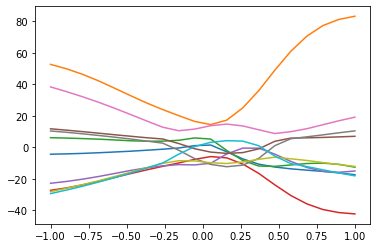

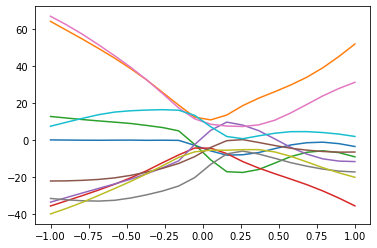

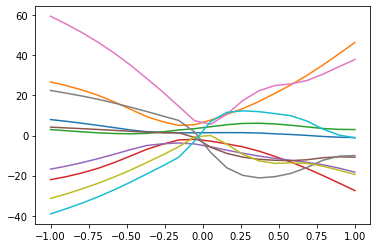

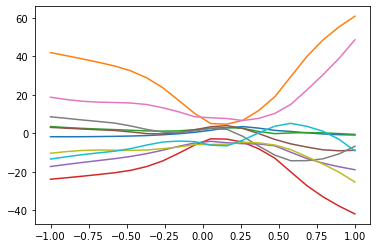

In [41]:
num_show = 10
for i in range(300):
    plt.plot(X[:,i], ys[:,i])#+X[:,i])
    if (i+1)%num_show == 0:
#         plt.axis("equal")
        plt.show()

In [42]:
# model = MLP_1()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# print("number of params: ", sum(p.numel() for p in model.parameters()))

In [43]:
# EPOCHS = 15
# steps_ = 0
# for epoch in range(EPOCHS):
#     train_acc = 0
#     train_count = 0
#     for index in range(train_size // batch_size):
#         steps_ += 1

#         train_x = train_data[index * batch_size:(index + 1) * batch_size]
#         train_y = train_label[index * batch_size:(index + 1) * batch_size]

#         yout = model(train_x)
#         loss = criterion(yout, train_y)
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if steps_%500==0:
#             print('\nTRAIN',epoch, steps_, '-> ', float(loss))
# #             yout = model.forward(train_data)
# #             outputs = tnn.Logits.logit_to_index(yout)
# #             correct = (outputs == np.array(train_label_)).sum()

# #             accuracy = correct / len(train_label_) * 100.
# #             print('EPOCH = ','accuracy = ', accuracy)
# #             print(correct, '/', len(train_label_))
            
#             with torch.no_grad():
#                 yout = model(test_data)
#             outputs = tnn.Logits.logit_to_index(yout.cpu().numpy())
#             correct = (outputs == np.array(test_label_)).sum()

#             accuracy = correct / len(test_label_) * 100.
#             print('   TEST  ','accuracy = ', accuracy)
#             print(correct, '/', len(test_label_))       

In [44]:
# model.l2.pos_mat

In [45]:
np.log2(128)

7.0